In [ ]:
from google.colab import auth
from datetime import datetime
import os
import numpy as np
import pandas as pd
from google.colab import drive
import torch
import torchaudio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import zipfile
import requests
from io import BytesIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

!git clone https://github.com/PK1725/MAE_AST_Public.git
!wget -nc https://www.cs.utexas.edu/~harwath/model_checkpoints/mae_ast/chunk_patch_75_12LayerEncoder.pt -O chunk_patch_75_12LayerEncoder.pth

!git clone https://github.com/facebookresearch/fairseq.git
os.chdir('fairseq')
!pip install ./
os.chdir('../')
from MAE_AST_Public.mae_ast_pretraining import MAE_AST_Pretraining_Config
from MAE_AST_Public.mae_ast_pretraining import MAE_AST_Pretraining_Task
from MAE_AST_Public.mae_ast import MAE_AST_Config
from MAE_AST_Public.mae_ast import MAE_AST
# Import .wav file from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Cloning into 'MAE_AST_Public'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 91 (delta 6), reused 6 (delta 6), pack-reused 82
Receiving objects: 100% (91/91), 37.54 KiB | 2.21 MiB/s, done.
Resolving deltas: 100% (28/28), done.
--2023-12-19 08:51:19--  https://www.cs.utexas.edu/~harwath/model_checkpoints/mae_ast/chunk_patch_75_12LayerEncoder.pt
Resolving www.cs.utexas.edu (www.cs.utexas.edu)... 128.83.120.48
Connecting to www.cs.utexas.edu (www.cs.utexas.edu)|128.83.120.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694304219 (662M)
Saving to: ‘chunk_patch_75_12LayerEncoder.pth’

chunk_patch_75_12La 100%[===================>] 662.14M  81.6MB/s    in 8.6s    

2023-12-19 08:51:29 (77.0 MB/s) - ‘chunk_patch_75_12LayerEncoder.pth’ saved [694304219/694304219]

Cloning into 'fairseq'...
remote: Enumerating objects: 34961, done.
remote: Counting objects: 100% (111/

In [ ]:
def wav2fbank(filename, filename2=None):
        # mixup
        if filename2 == None:
            waveform, sr = torchaudio.load(filename)
            waveform = waveform - waveform.mean()
        # mixup
        else:
            waveform1, sr = torchaudio.load(filename)
            waveform2, _ = torchaudio.load(filename2)

            waveform1 = waveform1 - waveform1.mean()
            waveform2 = waveform2 - waveform2.mean()

            if waveform1.shape[1] != waveform2.shape[1]:
                if waveform1.shape[1] > waveform2.shape[1]:
                    # padding
                    temp_wav = torch.zeros(1, waveform1.shape[1])
                    temp_wav[0, 0:waveform2.shape[1]] = waveform
                    waveform2 = temp_wav
                else:
                    # cutting
                    waveform2 = waveform2[0, 0:waveform1.shape[1]]

            # sample lambda from uniform distribution
            #mix_lambda = random.random()
            # sample lambda from beta distribtion
            mix_lambda = np.random.beta(10, 10)

            mix_waveform = mix_lambda * waveform1 + (1 - mix_lambda) * waveform2
            waveform = mix_waveform - mix_waveform.mean()

        fbank = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                                                  window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)

        target_length = 1024
        n_frames = fbank.shape[0]

        p = target_length - n_frames

        # cut and pad
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:target_length, :]

        if filename2 == None:
            return fbank, 0
        else:
            return fbank, mix_lambda
def norm_fbank(fbank):
    norm_mean= -4.2677393
    norm_std= 4.5689974
    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank
def display_fbank(bank, minmin=None, maxmax=None):
    plt.figure(figsize=(20, 4))
    plt.imshow(20*bank.T.numpy(), origin='lower', interpolation='nearest', vmax=maxmax, vmin=minmin,  aspect='auto')

In [ ]:
!pwd

/content


In [ ]:

# Create a new folder
drum_path = "drums"  # Adjust the path as needed
violin_path = "violins"  # Adjust the path as needed
viola_path = "violias"  # Adjust the path as needed
song1_path = "song1"  # Adjust the path as needed
song2_path = "song2"  # Adjust the path as needed



# Create the folder if it doesn't exist
if not os.path.exists(drum_path):
    os.makedirs(drum_path)
# Create the folder if it doesn't exist
if not os.path.exists(violin_path):
    os.makedirs(violin_path)
# Create the folder if it doesn't exist
if not os.path.exists(viola_path):
    os.makedirs(viola_path)
# Your modified Dropbox link
url_drum = 'https://www.dropbox.com/scl/fo/3r6y5rukigkeojz6rz3t8/h?rlkey=t8tkj85lepfql5vbjisq7a18n&dl=1'  # Replace with your modified link
url_violin = 'https://www.dropbox.com/scl/fo/3zmoanvnhskd0st2zrqtz/h?rlkey=fkya4kg6ztos6akb5t8dbcheb&dl=1'  # Replace with your modified link
url_viola = 'https://www.dropbox.com/scl/fo/t72jt36colnox67grne5q/h?rlkey=c52o84wuzpmwb6f8cjipl84xi&fbclid=IwAR2o2HiwiXdXiM3Q-eG-U9QAF2AXBKYpd85lL18USxx2wxIsm6Y0gO87r30&dl=1'
url_song1 = 'https://www.dropbox.com/scl/fo/ynvpkxxt8svyujbygjmhb/h?rlkey=dc5x0fe5baumy8h3oukydry0g&dl=1'#'https://www.dropbox.com/scl/fo/x06fvwzfd28labi4fludw/h?rlkey=832dt77ltthopggsqin7gv0m1&fbclid=IwAR0zvTeVtlVt0SJhGF6Le2yOXNStQG7s5cT59LblecLs-4Iae9nK96Zi_xk&dl=1'
url_song2 = 'https://www.dropbox.com/scl/fo/ahxcyxzeesu496zbedoac/h?rlkey=tru7pweiz5sss90dow9l9n5gs&dl=1'#'https://www.dropbox.com/scl/fo/8radowlyi58cmrrk8q4as/h?rlkey=p8h0ej2tmupcdk5kihazqewan&fbclid=IwAR0fktqEidDXj1f6ebxNa_bzkw9coCDaUkoDQ9CsEDLI0fh538tqRP2lA_4&dl=1'


# Send a request to the URL
response = requests.get(url_drum)

# Open the response content in bytes, then extract and save it in the new folder
with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(drum_path)

# Send a request to the URL
response = requests.get(url_violin)

# Open the response content in bytes, then extract and save it in the new folder
with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(violin_path)
# Send a request to the URL
response = requests.get(url_viola)

# Open the response content in bytes, then extract and save it in the new folder
with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(viola_path)

response = requests.get(url_song1)

# Open the response content in bytes, then extract and save it in the new folder
with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(song1_path)

response = requests.get(url_song2)

# Open the response content in bytes, then extract and save it in the new folder
with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(song2_path)

print("Download and extraction complete!")

Download and extraction complete!


In [ ]:
from types import SimpleNamespace
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load('/content/chunk_patch_75_12LayerEncoder.pth',map_location=device)
ast_mdl = MAE_AST(SimpleNamespace(**checkpoint["cfg"]["model"]), SimpleNamespace(**checkpoint["cfg"]["task"]))
ast_mdl = ast_mdl.to(device)
ast_mdl.load_state_dict(checkpoint["model"],strict=True)
ast_mdl.encoder.layerdrop = 0

from torch.nn.utils.rnn import pad_sequence


In [ ]:
def filter_wav_elements(input_list):
    return [element for element in input_list if element.endswith(".wav")]

# Generate representations
data_drums_path = 'drums'
data_violin_path = 'violins'
data_viola_path = 'violias'
data_song1_path = 'song1'
data_song2_path = 'song2'

# List all files in the specified folder
data_drums = os.listdir(data_drums_path)
data_drums = filter_wav_elements(data_drums)
data_violin = os.listdir(data_violin_path)
data_violin = filter_wav_elements(data_violin)
data_viola = os.listdir(data_viola_path)
data_viola = filter_wav_elements(data_viola)

data_song1 = os.listdir(data_song1_path)
data_song1 = filter_wav_elements(data_song1)
data_song2 = os.listdir(data_song2_path)
data_song2 = filter_wav_elements(data_song2)

import random

min_data_length = np.min([len(data_song1),len(data_song2)])
song_indices = list(range(min_data_length))

n_test = 20

test_set_indices = random.sample(song_indices, n_test)


test_class1 = [data_song1[i] for i in test_set_indices]
test_class2 = [data_song2[i] for i in test_set_indices]
train_class1 =[data_song1[i] for i in song_indices if i not in test_set_indices]
train_class2 =[data_song2[i] for i in song_indices if i not in test_set_indices]



X = np.zeros((len(train_class1)+len(train_class2),768))
X_test = np.zeros((len(test_class1)+len(test_class2),768))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i,clip in enumerate(train_class1):
  fbank,_ = wav2fbank("song1/" + clip)
  fbank = fbank.to(device)
  features = [fbank]
  feature_lengths = torch.LongTensor([len(feature) for feature in features]).to(device)
  feature_padding_mask = ~torch.lt(
      torch.arange(max(feature_lengths)).unsqueeze(0).to(device),
      feature_lengths.unsqueeze(1),
  )
  padded_features = pad_sequence(features, batch_first=True)
  representation = torch.mean(ast_mdl(padded_features, padding_mask=feature_padding_mask, mask=False, features_only=True, is_decoder_finetune=False)['x'],dim=1).cpu().detach().numpy()
  X[i,:] = representation

for i,clip in enumerate(test_class1):
  fbank,_ = wav2fbank("song1/" + clip)
  fbank = fbank.to(device)
  features = [fbank]
  feature_lengths = torch.LongTensor([len(feature) for feature in features]).to(device)
  feature_padding_mask = ~torch.lt(
      torch.arange(max(feature_lengths)).unsqueeze(0).to(device),
      feature_lengths.unsqueeze(1),
  )
  padded_features = pad_sequence(features, batch_first=True)
  representation = torch.mean(ast_mdl(padded_features, padding_mask=feature_padding_mask, mask=False, features_only=True, is_decoder_finetune=False)['x'],dim=1).cpu().detach().numpy()
  X_test[i,:] = representation

for i,clip in enumerate(train_class2):
  fbank,_ = wav2fbank("song2/" + clip)
  fbank = fbank.to(device)
  features = [fbank]
  feature_lengths = torch.LongTensor([len(feature) for feature in features]).to(device)
  feature_padding_mask = ~torch.lt(
      torch.arange(max(feature_lengths)).unsqueeze(0).to(device),
      feature_lengths.unsqueeze(1),
  )
  padded_features = pad_sequence(features, batch_first=True)
  representation = torch.mean(ast_mdl(padded_features, padding_mask=feature_padding_mask, mask=False, features_only=True, is_decoder_finetune=False)['x'],dim=1).cpu().detach().numpy()
  X[i+len(train_class1),:] = representation

for i,clip in enumerate(test_class2):
  fbank,_ = wav2fbank("song2/" + clip)
  fbank = fbank.to(device)
  features = [fbank]
  feature_lengths = torch.LongTensor([len(feature) for feature in features]).to(device)
  feature_padding_mask = ~torch.lt(
      torch.arange(max(feature_lengths)).unsqueeze(0).to(device),
      feature_lengths.unsqueeze(1),
  )

  padded_features = pad_sequence(features, batch_first=True)
  representation = torch.mean(ast_mdl(padded_features, padding_mask=feature_padding_mask, mask=False, features_only=True, is_decoder_finetune=False)['x'],dim=1).cpu().detach().numpy()
  X_test[i+len(test_class1),:] = representation

y = np.concatenate((np.zeros(len(train_class1)), np.ones(len(train_class2))))
y_test = np.concatenate((np.zeros(len(test_class1)), np.ones(len(test_class2))))



In [ ]:
#clf = svm.SVC()
#clf = KNeighborsClassifier(n_neighbors=4)
clf = LogisticRegression(random_state=0)
clf.fit(X, y)
preds = clf.predict(X_test)
print(preds)
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, preds)
print(acc)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.95


In [ ]:
import os
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
# Concatenate the training and test data
X_combined = np.vstack((X, X_test))
# Calculate t-SNE embeddings for the combined data
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_embeddings = tsne.fit_transform(X_combined)

# Separate the t-SNE embeddings for training and test data
tsne_train = tsne_embeddings[:len(X)]
tsne_test = tsne_embeddings[len(X):]


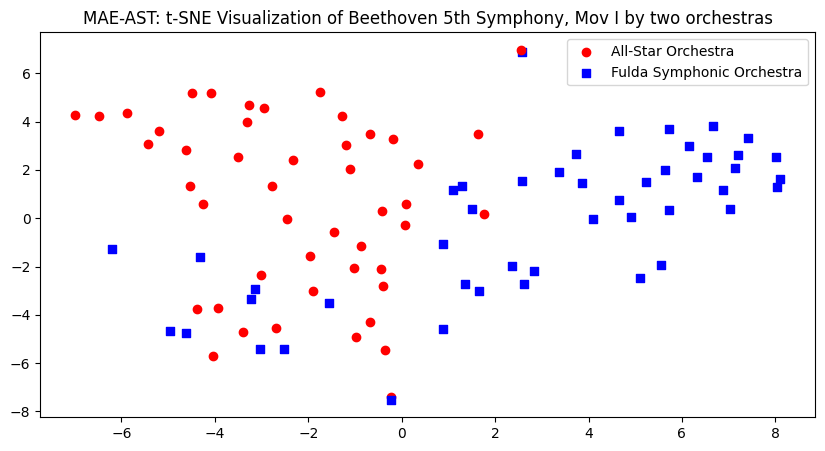

In [ ]:

# Create a scatter plot for training data
plt.figure(figsize=(10, 5))
plt.scatter(tsne_train[y == 0, 0], tsne_train[y == 0, 1], label='All-Star Orchestra', c='r', marker='o')
plt.scatter(tsne_train[y == 1, 0], tsne_train[y == 1, 1], label='Fulda Symphonic Orchestra', c='b', marker='s')


plt.scatter(tsne_test[y_test == 0, 0], tsne_test[y_test == 0, 1], c='r', marker='o')
plt.scatter(tsne_test[y_test == 1, 0], tsne_test[y_test == 1, 1], c='b', marker='s')

# Add labels and legend
plt.title('MAE-AST: t-SNE Visualization of Beethoven 5th Symphony, Mov I by two orchestras')
plt.legend()
# Show the plot
plt.show()

# RELAX


In [ ]:
import torch
import torchvision
import torch.nn as nn
import tqdm.notebook as tqdm
import torch.nn.functional as F
import matplotlib.gridspec as gridspec

from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms.functional import pil_to_tensor
from torchvision.transforms import ToTensor, Normalize, Resize

In [ ]:
def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

In [ ]:
def MaskGenerator(iterations, inp_width,inp_height, num_cells=7, mask_bs=2, p=0.5, nsd=2, dev='cpu'):
    for iteration in range(iterations):

        pad_size = (num_cells // 2, num_cells // 2, num_cells // 2, num_cells // 2)
        grid = (torch.rand(mask_bs, 1, *((num_cells,) * nsd), device=dev) < p).float()

        grid_up = F.interpolate(grid, size=(inp_width,inp_height), mode='bilinear', align_corners=False)
        grid_up = F.pad(grid_up, pad_size, mode='reflect')

        shift_x = torch.randint(0, num_cells, (mask_bs,), device=dev)
        shift_y = torch.randint(0, num_cells, (mask_bs,), device=dev)

        masks = torch.empty((mask_bs, 1, inp_width, inp_height), device=dev)

        for i in range(mask_bs):
            masks[i] = grid_up[i, :,
                               shift_x[i]:shift_x[i] + inp_width,
                               shift_y[i]:shift_y[i] + inp_height]

        yield masks


In [ ]:
def batched_yield(masks, batch_size=100):
    n_combinations = masks.size(0)
    for start_idx in range(0, n_combinations, batch_size):
        end_idx = min(start_idx + batch_size, n_combinations)
        yield masks[start_idx:end_idx], end_idx-start_idx

def MaskFrequencyGenerator(inp_width,inp_height, num_bands=[1,2,3],p=[0.1,0.2,0.3], dev='cpu'):
    """num_bands is a list containting numbers indicating how many bands of frequency should be masked at a time
    p are the masking percentage of the frequencies for each number of bands, the band sizes adjust to conform with this percentage.
    """
    from itertools import combinations
    import math

    for masking_pct,num_band in zip(p,num_bands):
      band_height = int((inp_height * masking_pct) // num_band) # how tall a band should be so that the bands cover masking_pct of the frequencies
      num_position = math.ceil(inp_height / band_height) # how many potential positions can a band be in
      n_combinations = special.binom(num_position, num_band).astype(int) # how many unique ways can we mask the frequencies given the parameters?
      masks = torch.ones(n_combinations,1,inp_width,inp_height, device=dev)
      for i,combo in enumerate(combinations(range(num_position), num_band)):  # loop through combinations
        combo = np.asarray(combo)
        combo = (combo*band_height).astype(int) # find starting indexes of band
        for idx in combo:
          masks[i,0,:,idx:min(idx+band_height,inp_height)] = 0
      yield from batched_yield(masks)
def MaskTimeGenerator(inp_width,inp_height, num_bands=[1,2,3],p=[0.1,0.2,0.3], dev='cpu'):
    """num_bands is a list containting numbers indicating how many bands of frequency should be masked at a time
    p are the masking percentage of the frequencies for each number of bands, the band sizes adjust to conform with this percentage.
    """
    from itertools import combinations
    import math

    for masking_pct,num_band in zip(p,num_bands):
      band_width = int((inp_width * masking_pct) // num_band) # how tall a band should be so that the bands cover masking_pct of the frequencies
      num_position = math.ceil(inp_width / band_width) # how many potential positions can a band be in
      n_combinations = special.binom(num_position, num_band).astype(int) # how many unique ways can we mask the frequencies given the parameters?
      masks = torch.ones(n_combinations,1,inp_width,inp_height, device=dev)
      for i,combo in enumerate(combinations(range(num_position), num_band)):  # loop through combinations
        combo = np.asarray(combo)
        combo = (combo*band_width).astype(int) # find starting indexes of band
        for idx in combo:
          masks[i,0,idx:min(idx+band_width,inp_width),:] = 0
      yield from batched_yield(masks)

def MaskTimeFrequencyGenerator(inp_width,inp_height, num_bands_time=[1,2,3],p_time=[0.1,0.2,0.3],num_bands_freq=[1,2,3],p_freq=[0.1,0.2,0.3], dev='cpu'):
  yield from MaskTimeGenerator(inp_width,inp_height, num_bands_time,p_time, dev=dev)
  yield from MaskFrequencyGenerator(inp_width,inp_height, num_bands_freq,p_freq, dev=dev)

In [ ]:
def prepare_for_plot(bank, minmin=None, maxmax=None):
    return bank.cpu().T.numpy()

In [ ]:
torch.cuda.empty_cache() # use this to free GPU memory

In [ ]:
fbank,_ = wav2fbank("violins/segment_10.wav")
#fbank,_ = wav2fbank("drums/combined_0.wav")

# move target to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fbank = fbank.to(device)

In [ ]:
def MAE_ast_model(fbank):
  features = [fbank]
  feature_lengths = torch.LongTensor([len(feature) for feature in features]).to(device)
  feature_padding_mask = ~torch.lt(
      torch.arange(max(feature_lengths)).unsqueeze(0).to(device),
      feature_lengths.unsqueeze(1),
  )
  padded_features = pad_sequence(features, batch_first=True)
  representation = torch.mean(ast_mdl(padded_features, padding_mask=feature_padding_mask, mask=False, features_only=True, is_decoder_finetune=False)['x'],dim=1)
  return representation

# Random Masking


In [ ]:
torch.manual_seed(100)

pdist = nn.CosineSimilarity(dim=1)

model_name_list = ['MAE-AST']
model_list = [MAE_ast_model]

mask_bs, inp_width, inp_height, num_batches = 100,1024,128,80

x = fbank

device = 'cuda'

with torch.no_grad():
  for model_loader, model_name in zip(model_list, model_name_list):

      model = model_loader
      h_star = model(x)
      h_star = h_star.expand(mask_bs, -1)


      saliency = torch.zeros((inp_width, inp_height), device=device)
      saliency_var = torch.zeros((inp_width, inp_height), device=device)

      for mask_idx, mask in enumerate(tqdm.tqdm(MaskGenerator(
                                                      num_batches, inp_width,inp_height, mask_bs=mask_bs,dev=device),
                                                      total=num_batches,
                                                      desc=f"Compute {model_name} importance")):

            x_mask = x.min() + mask*(x-x.min())
            x_mask = x_mask.squeeze(0)
            x_mask = x_mask.squeeze(1)
            x_mask = x_mask.squeeze(2)
            out = model(x_mask)

            out = pdist(h_star, out)[:, None, None, None]

            saliency += torch.mean(out * mask, dim=(0, 1))

      saliency /= (num_batches*0.5)

      for mask_idx, mask in enumerate(tqdm.tqdm(MaskGenerator(num_batches, inp_width,inp_height, mask_bs=mask_bs,dev=device),
                              total=num_batches, desc=f"Compute {model_name} uncertainty")):

          x_mask = x.min() + mask*(x-x.min())
          x_mask = x_mask.squeeze(1)

          out = model(x_mask)

          out = pdist(h_star, out)[:, None, None, None]

          var = (out-saliency[None, None])**2
          var = torch.mean(var * mask, dim=(0, 1))

          saliency_var += var

      saliency_var /= ((num_batches-1)*0.5)

Compute MAE-AST importance:   0%|          | 0/80 [00:00<?, ?it/s]

ValueError: ignored